# Toxicity Classification:

### 1. Business Problem:

**Source:** https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification<br><br>
**Description:** https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview/description<br><br>
**Problem Statement:** Given a comment made by the user, predict the toxicity of the comment.<br><br>

### 2. Machine Learning Problem Formulation:

#### 2.1 Data: <br>

- Source: https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data
- We have one single csv file for training and one cvs file to test.
- Columns in train data:
    - Comment_text: This is the data in string format which we have to use to find the toxicity.
    - target: Target values which are to be predicted (has values between 0 and 1)
    - Data also has additional toxicity subtype attributes: (Model does not have to predict these)
        - severe_toxicity
        - obscene
        - threat
        - insult
        - identity_attack
        - sexual_explicit
    - Comment_text data also has identity attributes carved out from it, some of which are:
        - male
        - female
        - homosexual_gay_or_lesbian
        - christian
        - jewish
        - muslim
        - black
        - white
        - asian
        - latino
        - psychiatric_or_mental_illness
    - Apart from above features the train data also provides meta-data from jigsaw like:
        - toxicity_annotator_count
        - identity_anotator_count
        - article_id
        - funny
        - sad
        - wow
        - likes
        - disagree
        - publication_id
        - parent_id
        - article_id
        - created_date
        

#### 2.2 Example Datapoints and Labels:<br>

**Comment:** i'm a white woman in my late 60's and believe me, they are not too crazy about me either!!<br><br>

- Toxicity Labels: All 0.0
- Identity Mention Labels: female: 1.0, white: 1.0 (all others 0.0)

**Comment:** Why would you assume that the nurses in this story were women?<br><br>

- Toxicity Labels: All 0.0
- Identity Mention Labels: female: 0.8 (all others 0.0)

**Comment:** Continue to stand strong LGBT community. Yes, indeed, you'll overcome and you have.<br><r>

- Toxicity Labels: All 0.0
- Identity Mention Labels: homosexual_gay_or_lesbian: 0.8, bisexual: 0.6, transgender: 0.3 (all others 0.0)



#### 2.3 Type of Machine Learning Problem:<br>

We have to predict the toxicity level(target attribute). The values range from 0 to 1 inclusive. This is a regression problem. It can also be treated as a classification problem if we take every value below 0.5 to be non-toxic and above it to be toxic, we would then get a binary classification problem.



#### 2.4 Performance Metric:

The competition will use ROC_AUC as the metric after converting the numeric target variable into a categorical variable by using a threshold of 0.5. Any comment above 0.5 will be assumed to be toxic and below it non-toxic. For our training and evaluation we will use the MSE(Mean Squared Error).<br>
More on evaluation: https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview/evaluation



#### 2.5 Machine Learning Objectives and Constraints:<br>

**Objectives:** Predict the toxicity of a comment made by the user. (0 -> not toxic, 1 -> highest toxicity level)

**Constraints:**
- The model should be fast to predict the toxicity rating.
- Interpretability is not needed.

## Importing Libraries:

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
import math
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
import gensim
import string
import tensorflow as tf
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
import warnings
from keras import backend as K
warnings.filterwarnings("ignore")
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

## Reading Data:

In [9]:
train_df = pd.read_csv('train.csv', index_col='id', engine='python')
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [10]:
test_df = pd.read_csv('test.csv', index_col='id', engine='python')
test_df.head()

,comment_text
id,
7000000,Jeff Sessions is another one of Trump's Orwell...
7000001,I actually inspected the infrastructure on Gra...
7000002,No it won't . That's just wishful thinking on ...
7000003,Instead of wringing our hands and nibbling the...
7000004,how many of you commenters have garbage piled ...


In [4]:
train_df.describe()

,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,...,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,405130.000000,405130.000000,405130.000000,405130.000000,...,1.026228e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,1.030173e-01,4.582099e-03,1.387721e-02,2.263571e-02,8.115273e-02,9.311271e-03,0.011964,0.003205,0.001884,0.034393,...,3.722687e+06,2.813597e+05,2.779269e-01,4.420696e-02,1.091173e-01,2.446167e+00,5.843688e-01,6.605974e-03,1.439019e+00,8.784694e+00
std,1.970757e-01,2.286128e-02,6.460419e-02,7.873156e-02,1.760657e-01,4.942218e-02,0.087166,0.050193,0.026077,0.167900,...,2.450261e+06,1.039293e+05,1.055313e+00,2.449359e-01,4.555363e-01,4.727924e+00,1.866589e+00,4.529782e-02,1.787041e+01,4.350086e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,6.100600e+04,2.006000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,7.960188e+05,1.601200e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,5.222993e+06,3.321260e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
75%,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,5.775758e+06,3.662370e+05,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,...,6.333965e+06,3.995410e+05,1.020000e+02,2.100000e+01,3.100000e+01,3.000000e+02,1.870000e+02,1.000000e+00,1.866000e+03,4.936000e+03


**Looking at count values of asian,atheist etc columns we see that there are a lot of Null values present, but this is OK as we are only supposed to use 'comment_text' column so dealing with these is not really necessary here.**

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1804874 entries, 59848 to 6334010
Data columns (total 44 columns):
target                                 float64
comment_text                           object
severe_toxicity                        float64
obscene                                float64
identity_attack                        float64
insult                                 float64
threat                                 float64
asian                                  float64
atheist                                float64
bisexual                               float64
black                                  float64
buddhist                               float64
christian                              float64
female                                 float64
heterosexual                           float64
hindu                                  float64
homosexual_gay_or_lesbian              float64
intellectual_or_learning_disability    float64
jewish                                

In [6]:
train_df.isnull().sum()

target                                       0
comment_text                                 0
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male                                   1399744
muslim       

**No Null values for target and comment_text columns**

In [7]:
print("Train and test shape: {} {}".format(train_df.shape, test_df.shape))

Train and test shape: (1804874, 44) (97320, 1)


## Exploratory Data Analysis:

### 1. Target Feature:

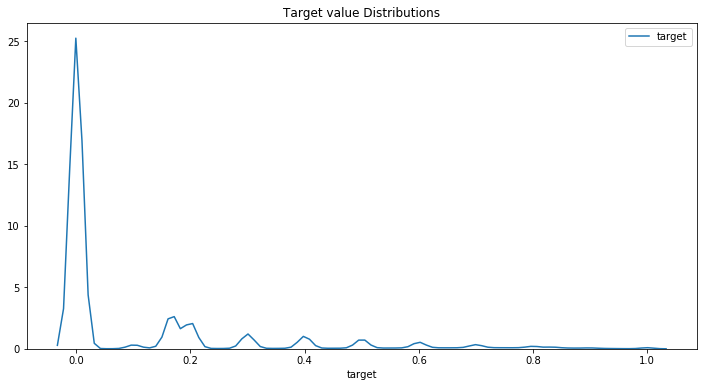

In [8]:
plt.figure(figsize=(12,6))
plt.title("Target value Distributions")
sns.distplot(train_df['target'], kde=True, hist=False, bins=240, label='target')
plt.show()

**We see that most of the comments present in the dataset are actually non-toxic (<0.5) and only a few of them are actually toxic (>0.5)**

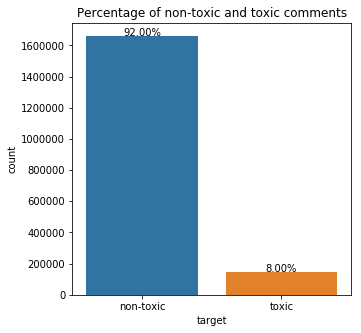

In [9]:
# If toxicity rating < 0.5 then the comment is non-toxic else it is toxic.
# Get toxic and non-toxic comments.
temp = train_df['target'].apply(lambda x: "non-toxic" if x < 0.5 else "toxic")

# Plot the number and percentage of toxic and non-toxic comments.
fig, ax = plt.subplots(1,1,figsize=(5,5))
total = float(len(temp))

# Plot the count plot.
cntplot = sns.countplot(temp)
cntplot.set_title('Percentage of non-toxic and toxic comments')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

**The dataset is imbalanced as 92% of the comments are non-toxic and only 8% are toxic**

### 2. Toxicity Subtype Features:
- severe_toxicity
- obscene
- threat
- insult
- identity_attack

In [10]:
# Code from: https://www.kaggle.com/gpreda/jigsaw-eda
# Modified a bit according to my needs
def plot_features_distribution(features, title, data):
    plt.figure(figsize=(12,6))
    plt.title(title)
    for feature in features:
        sns.distplot(data[feature],kde=True,hist=False, bins=240, label=feature)
    plt.xlabel('')
    plt.legend()
    plt.show()

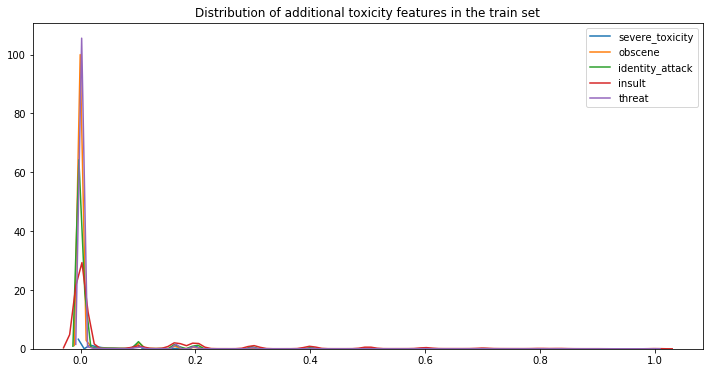

In [11]:
features = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
plot_features_distribution(features, "Distribution of additional toxicity features in the train set", train_df)

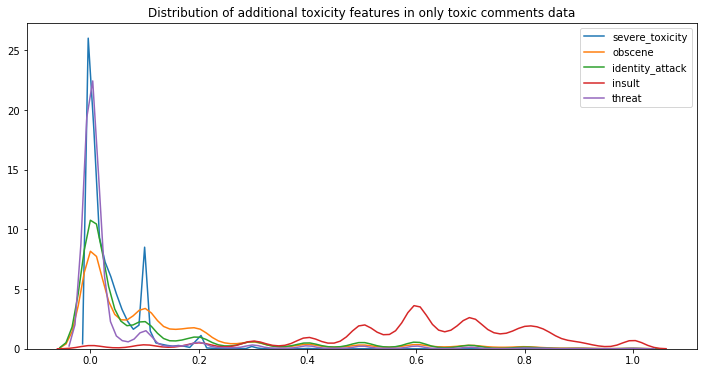

In [12]:
# Looking at the distribution of additional toxicity features on the comments that are actually considered toxic:
temp = train_df[train_df['target'] > 0.5]
plot_features_distribution(features, "Distribution of additional toxicity features in only toxic comments data", temp)

**We see that for toxic comments data, there are more insulting comments as compared to obscene comments**

In [13]:
# Getting the count of additonal toxicity features in toxic comments data(temp):
def get_comment_nature(row):
    # Extract type of toxic comment
    row = [row['severe_toxicity'], row['obscene'], row['identity_attack'], row['insult'], row['threat']]
    
    maxarg = np.argmax(np.array(row)) # Get the max value index.
    
    if maxarg == 0: return 'severe_toxicity'
    elif maxarg == 1: return 'obscene'
    elif maxarg == 2: return 'identity_attack'
    elif maxarg == 3: return 'insult'
    else: return 'threat'

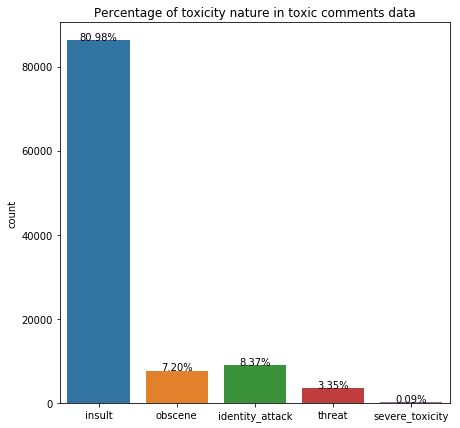

In [14]:
x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment
fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x)
cntplot.set_title('Percentage of toxicity nature in toxic comments data')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

**In our train dataset only 8% of the data was toxic. Out of that 8%, 81% of the toxic comments made are insults, 8.37% are identity attacks, 7.20% are obscene, 3.35% are threats and a very small amount of toxic comments are severly toxic.**

### 3. Identity Attributes:

Sensitive topics:

- male
- female
- homosexual_gay_or_lesbian
- bisexual
- heterosexual
- christian
- jewish
- muslim
- black
- white
- asian
- latino

In [15]:
temp = train_df.dropna(axis = 0, how = 'any')

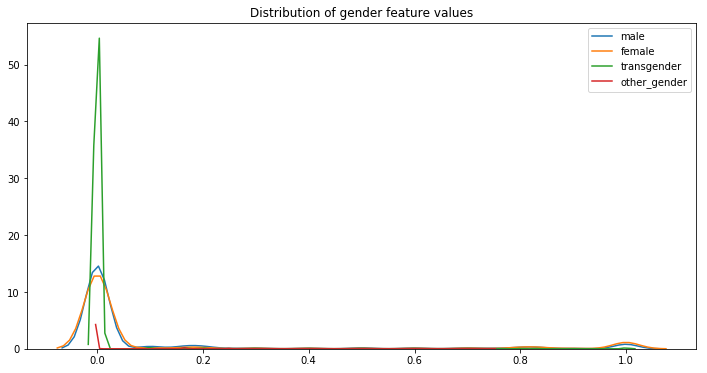

In [16]:
features = ['male', 'female', 'transgender', 'other_gender']
plot_features_distribution(features, "Distribution of gender feature values", temp)

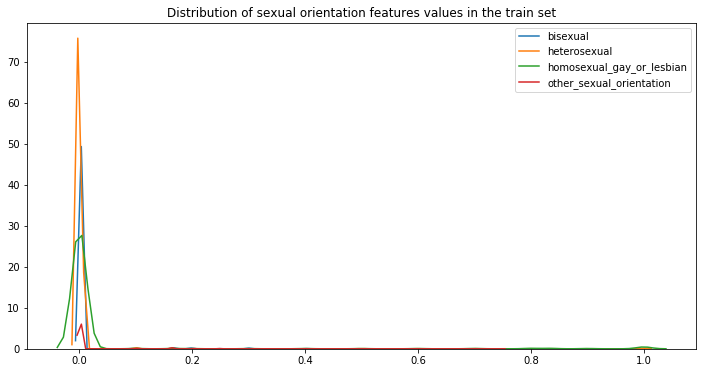

In [17]:
features = ['bisexual', 'heterosexual', 'homosexual_gay_or_lesbian', 'other_sexual_orientation']
plot_features_distribution(features, "Distribution of sexual orientation features values in the train set", temp)

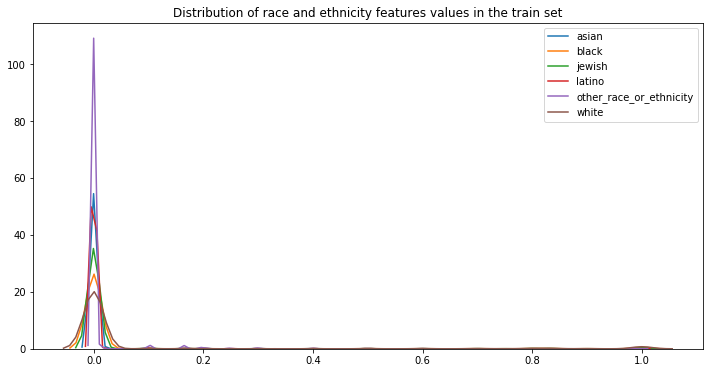

In [18]:
features = ['asian', 'black', 'jewish', 'latino', 'other_race_or_ethnicity', 'white']
plot_features_distribution(features, "Distribution of race and ethnicity features values in the train set", temp)

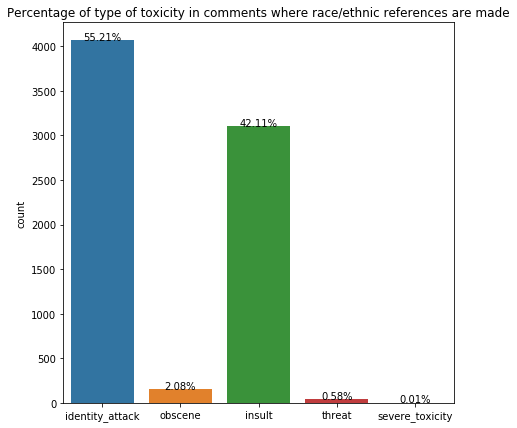

In [19]:
# Get data where race/ethnic references are made.
cond = (train_df['asian'] > 0.5) | (train_df['black'] > 0.5) | (train_df['jewish'] > 0.5) | (train_df['latino'] > 0.5) | (train_df['white'] > 0.5)
temp = train_df[cond] # Get data where race/ethnic references are made.
temp = temp[temp['target'] > 0.5] # Extract only toxic comments.

x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment

fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x)
cntplot.set_title('Percentage of type of toxicity in comments where race/ethnic references are made')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

**We see that the toxic comments involving words like black, asian etc. are mainly used for identity attacks or insults.**

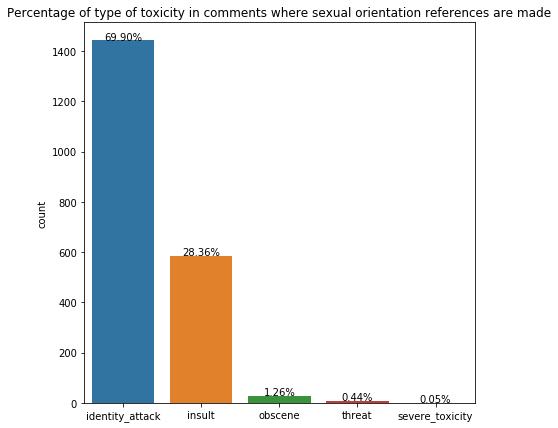

In [20]:
# Get data where race/ethnic references are made.
cond = (train_df['bisexual'] > 0.5) | (train_df['heterosexual'] > 0.5) | (train_df['homosexual_gay_or_lesbian'] > 0.5) | (train_df['other_sexual_orientation'] > 0.5) 
temp = train_df[cond] # Get data where race/ethnic references are made.
temp = temp[temp['target'] > 0.5] # Extract only toxic comments.

x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment

fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x)
cntplot.set_title('Percentage of type of toxicity in comments where sexual orientation references are made')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

**We see from the plot that the toxic comments where sexual orientation references are made are mostly used for identity attacks.** 

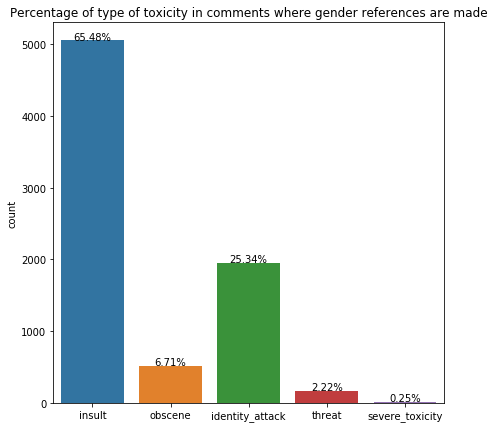

In [21]:
# Get data where race/ethnic references are made.
cond = (train_df['male'] > 0.5) | (train_df['female'] > 0.5) | (train_df['transgender'] > 0.5) | (train_df['other_gender'] > 0.5) 
temp = train_df[cond] # Get data where race/ethnic references are made.
temp = temp[temp['target'] > 0.5] # Extract only toxic comments.

x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment

fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x)
cntplot.set_title('Percentage of type of toxicity in comments where gender references are made')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

**From the plot we see that the toxic comments which involve words like male, female etc are insults.**

### 4. Features generated by users feedback:

- funny
- sad
- wow
- likes
- disagree

In [22]:
# Code from: https://www.kaggle.com/gpreda/jigsaw-eda
# Modified a bit
def plot_count(feature, title, data, size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(data))
    g = sns.countplot(data[feature], order = data[feature].value_counts().index[:20], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()   

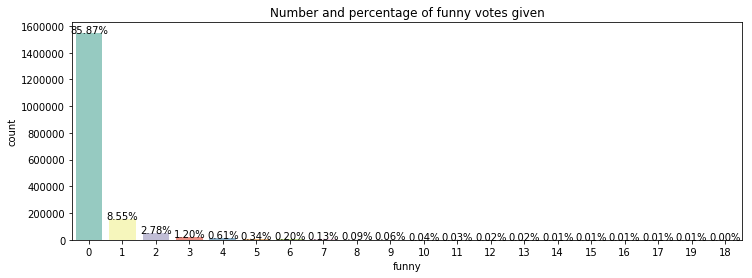

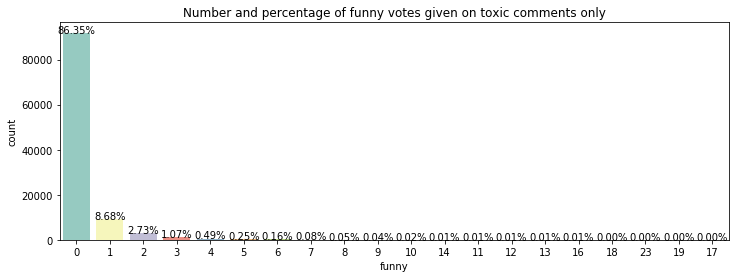

In [23]:
plot_count('funny','funny votes given', train_df, 3)
plot_count('funny', 'funny votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

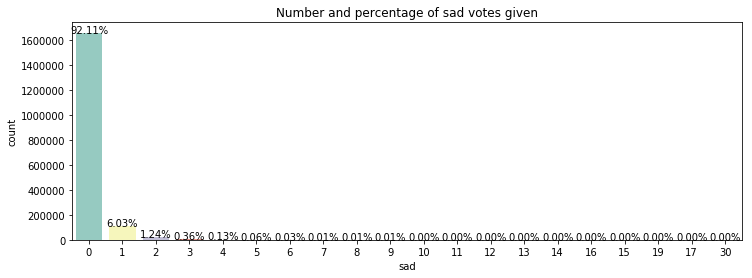

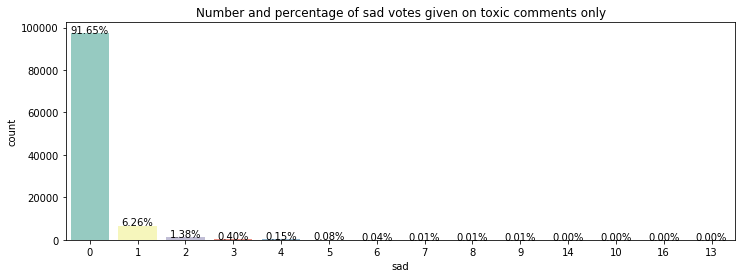

In [24]:
plot_count('sad','sad votes given', train_df, 3)
plot_count('sad', 'sad votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

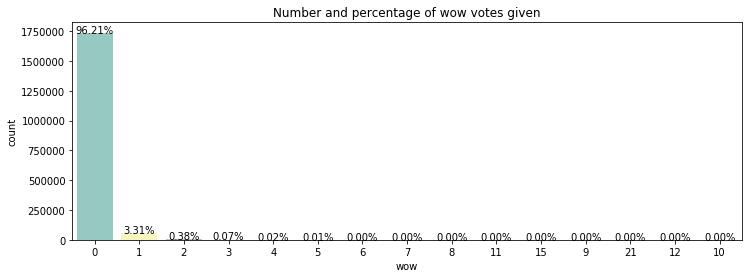

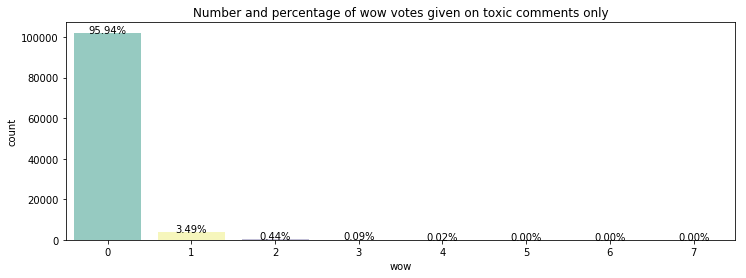

In [25]:
plot_count('wow','wow votes given', train_df, 3)
plot_count('wow', 'wow votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

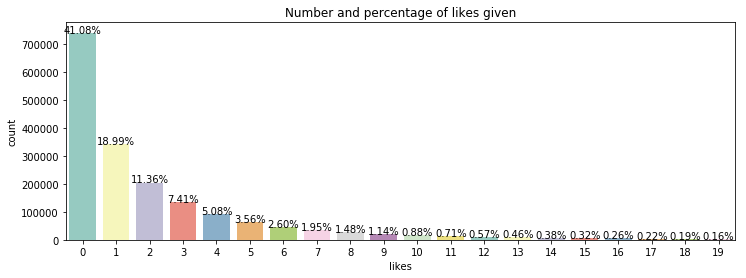

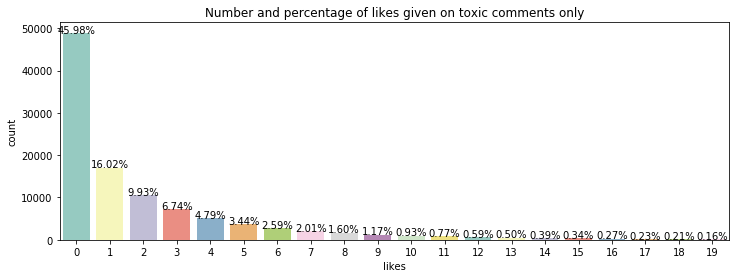

In [26]:
plot_count('likes','likes given', train_df, 3)
plot_count('likes', 'likes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

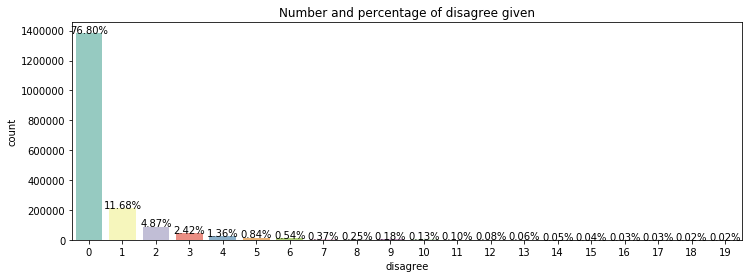

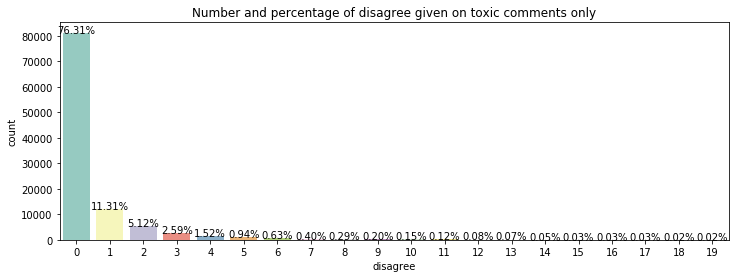

In [27]:
plot_count('disagree','disagree given', train_df, 3)
plot_count('disagree', 'disagree given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

### 5. Comments_text Feature:

In [28]:
# Code From: https://www.kaggle.com/gpreda/jigsaw-eda
stpwrds = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stpwrds,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

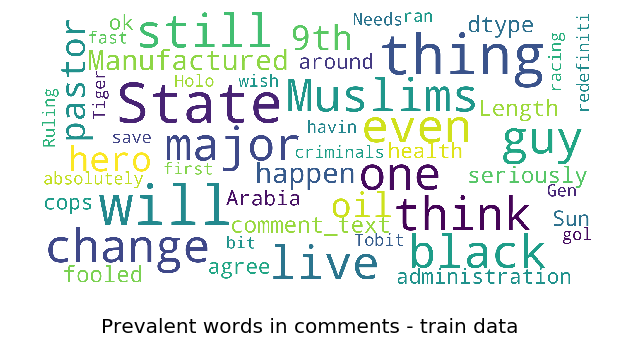

In [29]:
show_wordcloud(train_df['comment_text'].sample(20000), title = 'Prevalent words in comments - train data')

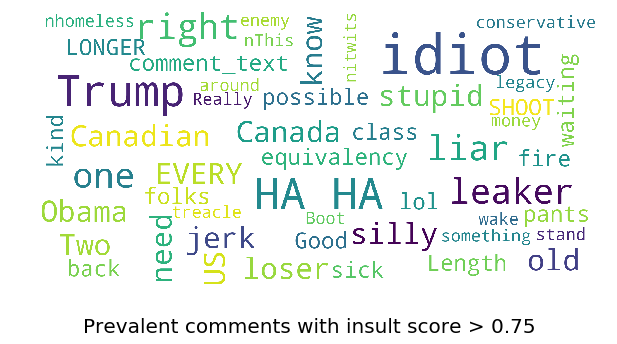

In [32]:
show_wordcloud(train_df.loc[train_df['insult'] > 0.75]['comment_text'].sample(20000), 
               title = 'Prevalent comments with insult score > 0.75')

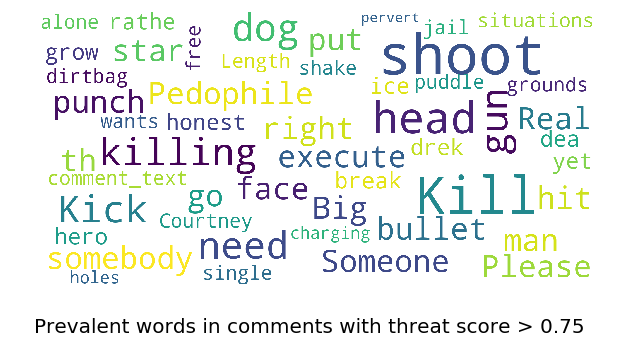

In [34]:
show_wordcloud(train_df.loc[train_df['threat'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with threat score > 0.75')

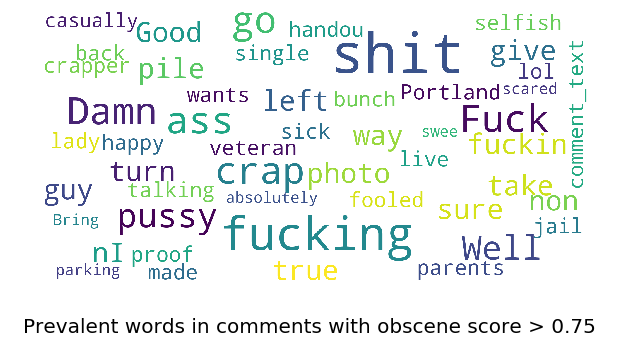

In [35]:
show_wordcloud(train_df.loc[train_df['obscene'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with obscene score > 0.75')

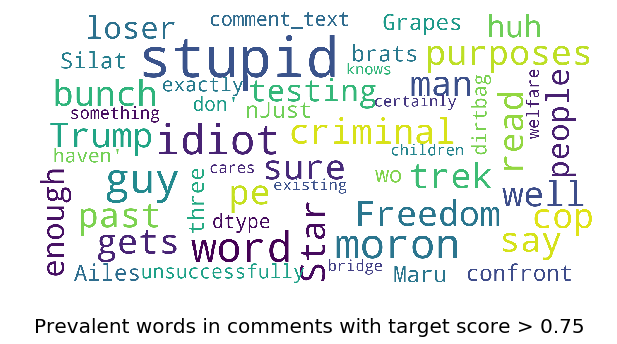

In [36]:
show_wordcloud(train_df.loc[train_df['target'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with target score > 0.75')

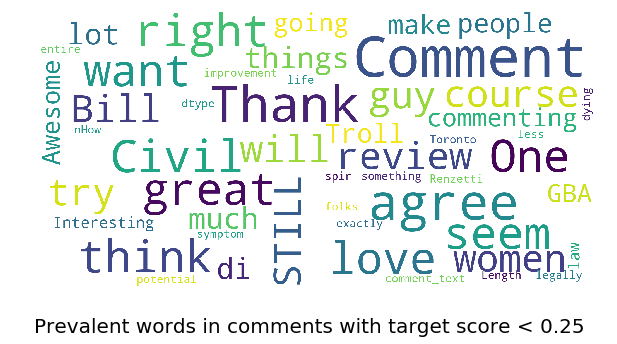

In [37]:
show_wordcloud(train_df.loc[train_df['target'] < 0.25]['comment_text'], 
               title = 'Prevalent words in comments with target score < 0.25')

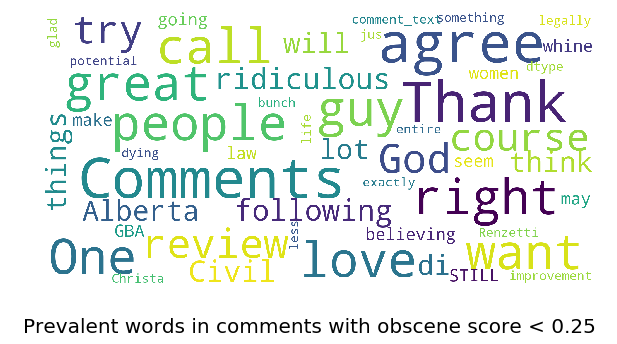

In [38]:
show_wordcloud(train_df.loc[train_df['obscene']< 0.25]['comment_text'], 
               title = 'Prevalent words in comments with obscene score < 0.25')

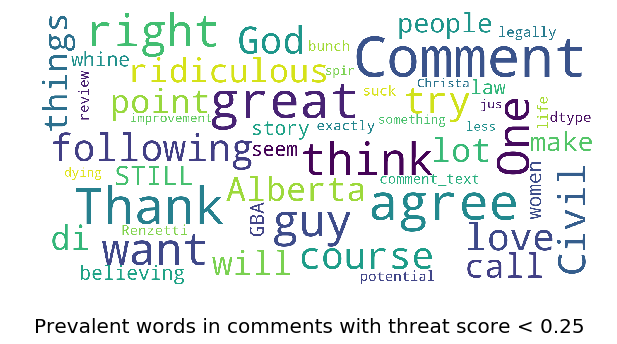

In [39]:
show_wordcloud(train_df.loc[train_df['threat'] < 0.25]['comment_text'], 
               title = 'Prevalent words in comments with threat score < 0.25')

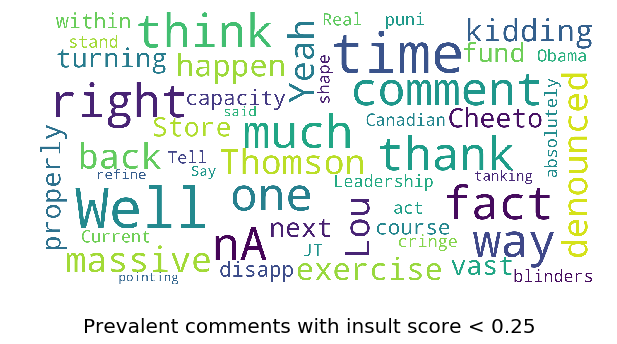

In [40]:
show_wordcloud(train_df.loc[train_df['insult'] < 0.25]['comment_text'].sample(20000), 
               title = 'Prevalent comments with insult score < 0.25')

## Preprocessing Text and Train-Test Split:

In [11]:
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))
def preprocess(text_string):
    text_string = text_string.lower() # Convert everything to lower case.
    text_string = re.sub('[^A-Za-z0-9]+', ' ', text_string) # Remove special characters and punctuations
    
    x = text_string.split()
    new_text = []
    
    for word in x:
        if word not in stop_words:
            new_text.append(stemmer.stem(word))
            
    text_string = ' '.join(new_text)
    return text_string

In [12]:
%%time
train_df['preprocessed_text'] = train_df['comment_text'].apply(preprocess)

CPU times: user 12min 56s, sys: 52 ms, total: 12min 56s
Wall time: 12min 56s


In [13]:
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,preprocessed_text
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,cool like would want mother read realli great ...
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,thank would make life lot less anxieti induc k...
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,urgent design problem kudo take impress
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,someth abl instal site releas
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,...,rejected,0,0,0,1,0,0.0,4,47,haha guy bunch loser


In [14]:
%%time
test_df['preprocessed_text'] = test_df['comment_text'].apply(preprocess)

CPU times: user 43 s, sys: 12 ms, total: 43 s
Wall time: 43 s


In [16]:
feature = train_df[['preprocessed_text']]
output = train_df[['target']]
X_train, X_cv, y_train, y_cv = train_test_split(feature, output)

print(X_train.shape)
print(X_cv.shape)
print(y_train.shape)
print(y_cv.shape)

(1353655, 1)
(451219, 1)
(1353655, 1)
(451219, 1)


In [17]:
X_train.head()

,preprocessed_text
id,
437306,sound like incred corrupt countri brazil tri p...
5362564,assum author actual month month rental agreeme...
5071745,free speech appli quebec provid critic quebec ...
5337906,sharehold right demand new energi technolog de...
5494555,stoner came law citat need


In [18]:
X_cv.head()

,preprocessed_text
id,
5682845,worri patron merchant ward king tide last laug...
386113,interest thing publish public suppos inform la...
5293705,1 look romero volumin diari archbishop mention...
864160,seem work tha aca
610294,well think worthwhil instead


In [19]:
X_test = test_df[['preprocessed_text']]
X_test.head()

,preprocessed_text
id,
7000000,jeff session anoth one trump orwellian choic b...
7000001,actual inspect infrastructur grand chief stewa...
7000002,wish think democrat fault 100 th time walker c...
7000003,instead wring hand nibbl peripheri issu face a...
7000004,mani comment garbag pile high yard bald tire d...


In [20]:
# Saving the files to csv so that we dont need to preprocess again.
X_train.to_pickle('X_train.pkl')
X_cv.to_pickle('X_cv.pkl')
X_test.to_pickle('X_test.pkl')
y_train.to_pickle('y_train.pkl')
y_cv.to_pickle('y_cv.pkl')

## Training Models:

In [2]:
# To load the csv files:
# Uncomment the block.
X_train = pd.read_pickle('X_train.pkl')
X_cv = pd.read_pickle('X_cv.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_cv = pd.read_pickle('y_cv.pkl')

### 1. Bag of Words (BoW):

In [23]:
cnt_vec = CountVectorizer(ngram_range=(1,2), max_features=30000)
bow_train = cnt_vec.fit_transform(X_train['preprocessed_text'])
bow_cv = cnt_vec.transform(X_cv['preprocessed_text'])
bow_test = cnt_vec.transform(X_test['preprocessed_text'])

print(bow_train.shape)
print(bow_cv.shape)
print(bow_test.shape)

(1353655, 30000)
(451219, 30000)
(97320, 30000)


#### 1.1 SGDRegressor:

##### 1.1.1 Hyperparameter Tuning:

In [29]:
# Performing hyperparameter tuning:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")
        
        model = SGDRegressor(alpha=a, penalty=p) 
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

1e-05 l1 :
Mean Squared Error on train set:  0.022818008001404367
Mean Squared Error on cv set:  0.023264486960947385
**************************************************
1e-05 l2 :
Mean Squared Error on train set:  0.022374656945494602
Mean Squared Error on cv set:  0.02307615793510582
**************************************************
0.0001 l1 :
Mean Squared Error on train set:  0.02442940779510918
Mean Squared Error on cv set:  0.024787770608924682
**************************************************
0.0001 l2 :
Mean Squared Error on train set:  0.02297856943532651
Mean Squared Error on cv set:  0.023125193862518406
**************************************************
0.001 l1 :
Mean Squared Error on train set:  0.03134862787342781
Mean Squared Error on cv set:  0.031712334235442396
**************************************************
0.001 l2 :
Mean Squared Error on train set:  0.023196009031646515
Mean Squared Error on cv set:  0.023723365744184762
***************************************

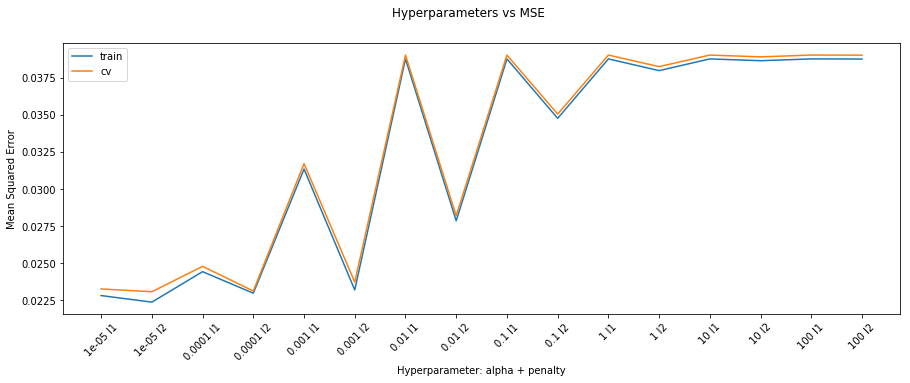

In [32]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(alpha) * len(penalty)), tr_errors)
plt.plot(range(len(alpha) * len(penalty)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyperparameter: alpha + penalty')
plt.ylabel('Mean Squared Error')
plt.show()

In [33]:
# Getting the best model parameters:
best_model.get_params()

{'alpha': 1e-05,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_loss',
 'max_iter': None,
 'n_iter': None,
 'n_iter_no_change': 5,
 'penalty': 'l2',
 'power_t': 0.25,
 'random_state': None,
 'shuffle': True,
 'tol': None,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

##### 1.1.2 Feature Importance:

In [37]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = cnt_vec.get_feature_names()
weights = best_model.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
idiot,0.424030
stupid,0.352597
moron,0.303459
pathet,0.294925
crap,0.283992
hypocrit,0.276049
ass,0.271104
dumb,0.264664
jerk,0.260505
clown,0.247974


In [38]:
# 20 most important features/words which contribute to comment being non-toxic.
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
stupid stupid,-0.132088
knee jerk,-0.065000
black white,-0.052025
fool peopl,-0.049659
ignor fact,-0.043924
winner loser,-0.041676
magaph,-0.038994
black market,-0.037910
get sick,-0.030661
white hous,-0.030483


#### 1.2 Decision Trees:

##### 1.2.1 Hyperparameter Tuning:

In [43]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.033038394352245766
Mean Squared Error on cv set:  0.03331258146917638
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03303839435224578
Mean Squared Error on cv set:  0.03331258146917638
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.03304091329264561
Mean Squared Error on cv set:  0.03331117452500498
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.031969622212608
Mean Squared Error on cv set:  0.03222098273350175
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03197301728516407
Mean Squared Error on cv set:  0.03221732742184004
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error on train s

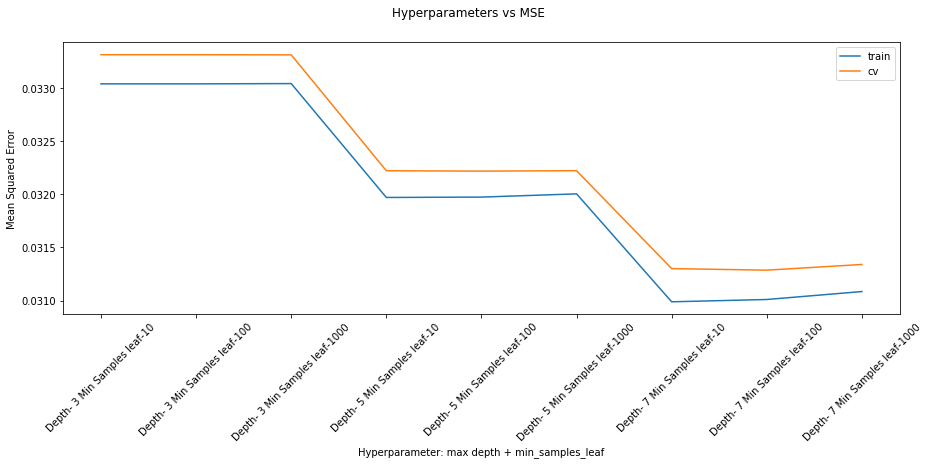

In [45]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

In [46]:
# Best models parameters:
best_model.get_params()

{'criterion': 'mse',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 100,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

##### 1.2.2 Feature Importance:

In [48]:
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.398455
idiot,0.264746
pathet,0.069932
fool,0.067759
moron,0.062533
racist,0.060099
hypocrit,0.055797
one,0.004503
year,0.003641
would,0.003595


### 2. Term Frequency - Inverse Document Frequency (TFIDF) :

In [3]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), max_features=30000)
tfidf_train = tfidf_vec.fit_transform(X_train['preprocessed_text'])
tfidf_cv = tfidf_vec.transform(X_cv['preprocessed_text'])
tfidf_test = tfidf_vec.transform(X_test['preprocessed_text'])

print(tfidf_train.shape)
print(tfidf_cv.shape)
print(tfidf_test.shape)

(1353655, 30000)
(451219, 30000)
(97320, 30000)


#### 2.1 SGDRegressor:

##### 2.1.1 Hyperparameter Tuning:

In [4]:
# Performing hyperparameter tuning:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")
        
        model = SGDRegressor(alpha=a, penalty=p) 
        model.fit(tfidf_train, y_train) # Train
        
        preds = model.predict(tfidf_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(tfidf_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

1e-05 l1 :
Mean Squared Error on train set:  0.026404974587497056
Mean Squared Error on cv set:  0.02666155318404788
**************************************************
1e-05 l2 :
Mean Squared Error on train set:  0.025564018274766023
Mean Squared Error on cv set:  0.025845038252021134
**************************************************
0.0001 l1 :
Mean Squared Error on train set:  0.030518810500870613
Mean Squared Error on cv set:  0.030791884090549428
**************************************************
0.0001 l2 :
Mean Squared Error on train set:  0.026090095393798612
Mean Squared Error on cv set:  0.02637116054047698
**************************************************
0.001 l1 :
Mean Squared Error on train set:  0.03827449063919194
Mean Squared Error on cv set:  0.03853501216406193
**************************************************
0.001 l2 :
Mean Squared Error on train set:  0.03025503220320849
Mean Squared Error on cv set:  0.030531407999188503
****************************************

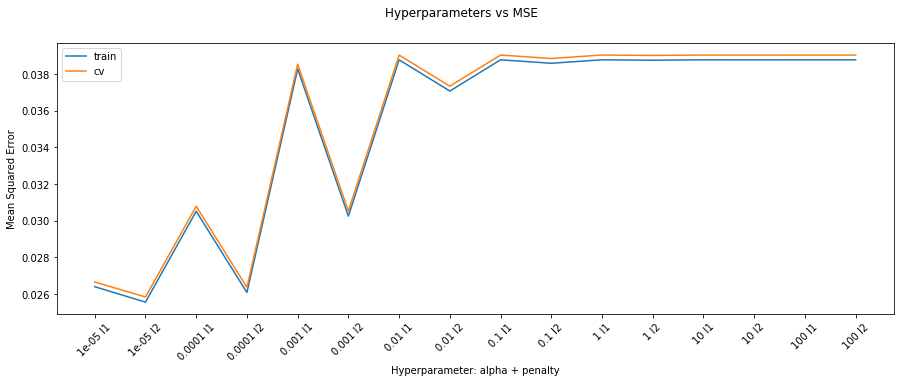

In [5]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(alpha) * len(penalty)), tr_errors)
plt.plot(range(len(alpha) * len(penalty)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyperparameter: alpha + penalty')
plt.ylabel('Mean Squared Error')
plt.show()

##### 2.1.2 Feature Importance:

In [6]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = tfidf_vec.get_feature_names()
weights = best_model.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,1.309539
idiot,1.040803
fool,0.522676
ignor,0.513465
dumb,0.461498
pathet,0.455982
white,0.444054
racist,0.442242
ridicul,0.439071
loser,0.437891


In [7]:
# 20 most important features/words which contribute to comment being non-toxic.
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
thank,-0.093605
interest,-0.081493
year,-0.070307
may,-0.068451
great,-0.068000
new,-0.067818
agre,-0.067784
stori,-0.066696
work,-0.066485
good,-0.066440


#### 2.2 Decision Trees:

##### 2.2.1 Hyperparameter Tuning:

In [8]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(tfidf_train, y_train) # Train
        
        preds = model.predict(tfidf_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(tfidf_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03283496829673914
Mean Squared Error on cv set:  0.03310723478779011
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.032834968296739146
Mean Squared Error on cv set:  0.03310723478779012
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.03283496829673914
Mean Squared Error on cv set:  0.03310723478779011
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03170907596306208
Mean Squared Error on cv set:  0.03193931892574044
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03171181111990478
Mean Squared Error on cv set:  0.03194162415359571
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error on train

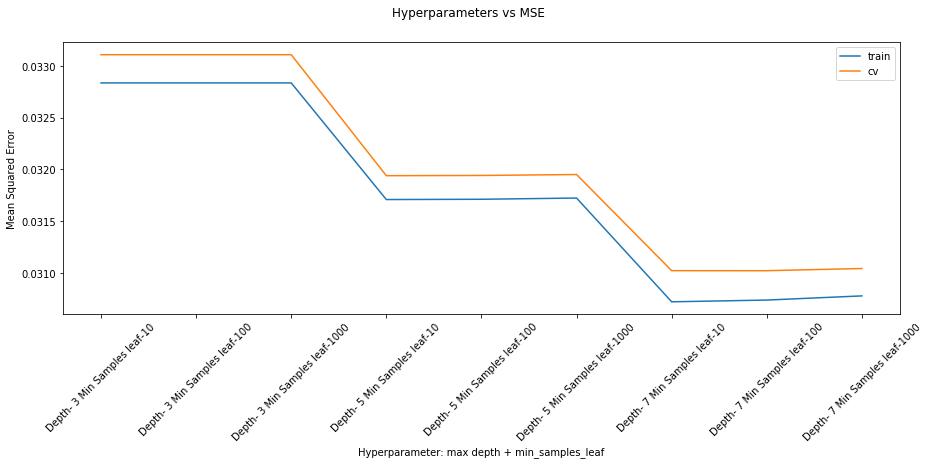

In [9]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

##### 2.2.2 Feature Importance:

In [10]:
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.407839
idiot,0.268618
pathet,0.072022
fool,0.071323
moron,0.063278
racist,0.058106
hypocrit,0.054024
white,0.002222
trump,0.000893
peopl,0.000535


### 3. Features for LSTM:

In [3]:
class LSTMFeaturization:
    
    def __init__(self):
        self.word_mapping = None
        self.total_words = None
        
    
    # Accepts a list of sentences and builds a vocabulary.
    def build_vocabulary(self, sentences):
        
        vocab = set()
        for x in sentences:
            for word in x.split():
                vocab.add(word)
        
        # Create a dictionary from vocabulary.
        vocab_dict = dict.fromkeys(vocab, 0)
        
        # Calculate count of each word..
        for x in sentences:
            for word in x.split():
                vocab_dict[word]+=1
                
        return vocab_dict
    
    
    
    # Accepts a dictionary (vocabulary) and gets the word number in dictionary format
    def get_mapping(self, vocab_dict):
                
        # Get the number of each word into the corpus.
        k = []
        v = []
        for keys,val in vocab_dict.items():
            k.append(keys)
            v.append(val)
            
        kv = np.vstack((k,v)).T
        df = pd.DataFrame(columns=["Word","Count"], data=kv)
        df['Count'] = df['Count'].astype('int')
        
        # Sort the dataframe to get the largest count at first place
        df.sort_values(by=['Count'], ascending=False, inplace=True)
        
        # Give numbering to the most frequent word as 1 then next as 2 and so on.
        df.reset_index(inplace=True)
        df['mapping'] = df.index + 1
        
        df.drop(columns=['index'], inplace=True)
        df.drop(columns=['Count'], inplace=True)
        
        # Convert to dictionary for easier processing.
        dictionary = dict(zip(df['Word'], df['mapping']))
        
        return dictionary
    
    
    # Accepts a list of sentences and generates vocabulary and word mappings.
    def fit(self, sentences):
        v = self.build_vocabulary(sentences)
        self.word_mapping = self.get_mapping(v)
        self.total_words = len(self.word_mapping)
        
    # Converts the sentences to number mappings.
    def transform(self, sentences, pad_length = 350):
        
        whole = list() # Stores mapping for all sentences
        for x in sentences: # for each sentence in list of sentences.
            
            part = list()
            for word in x.split(): # for each word
                if word in self.word_mapping:
                    part.append(self.word_mapping[word]) # Append mapped number.
            whole.append(part) # Append sentence.
        
        # Append additional values to make lengths equal.
        whole = keras.preprocessing.sequence.pad_sequences(np.array(whole), maxlen=pad_length)
        
        return whole

In [4]:
lstmfeat = LSTMFeaturization()
lstmfeat.fit(X_train['preprocessed_text'])

In [5]:
lstm_train = lstmfeat.transform(X_train['preprocessed_text'])
lstm_test = lstmfeat.transform(X_test['preprocessed_text'])
lstm_cv = lstmfeat.transform(X_cv['preprocessed_text'])

In [6]:
print(lstm_train.shape)
print(lstm_cv.shape)
print(lstm_test.shape)

(1353655, 350)
(451219, 350)
(97320, 350)


In [7]:
np.save('lstm_train.npy', lstm_train)
np.save('lstm_cv.npy', lstm_cv)
np.save('lstm_test.npy', lstm_test)

In [11]:
# create the model
embedding_vecor_length = 100
total_words = lstmfeat.total_words
model = Sequential()
model.add(Embedding(total_words ,embedding_vecor_length, input_length=350))
model.add(CuDNNLSTM(128, return_sequences=True))
model.add(CuDNNLSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 350, 100)          20121100  
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 350, 128)          117760    
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 128)               132096    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 20,371,085
Trainable params: 20,371,085
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [13]:
history = model.fit(lstm_train, y_train, nb_epoch=5,
                    batch_size=2048, validation_data=(lstm_cv, y_cv), verbose = 1, callbacks=callbacks_list)

Train on 1353655 samples, validate on 451219 samples
Epoch 1/5
1353655/1353655 [==============================] - 453s 334us/step - loss: 0.0204 - mean_squared_error: 0.0204 - val_loss: 0.0161 - val_mean_squared_error: 0.0161

Epoch 00001: val_loss improved from -inf to 0.01615, saving model to weights-improvement-01-0.02.hdf5
Epoch 2/5
1353655/1353655 [==============================] - 440s 325us/step - loss: 0.0157 - mean_squared_error: 0.0157 - val_loss: 0.0162 - val_mean_squared_error: 0.0162

Epoch 00002: val_loss improved from 0.01615 to 0.01616, saving model to weights-improvement-02-0.02.hdf5
Epoch 3/5
1353655/1353655 [==============================] - 439s 325us/step - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.0158 - val_mean_squared_error: 0.0158

Epoch 00003: val_loss did not improve from 0.01616
Epoch 4/5
1353655/1353655 [==============================] - 455s 336us/step - loss: 0.0148 - mean_squared_error: 0.0148 - val_loss: 0.0157 - val_mean_squared_error: 0

Text(0.5, 1.0, 'Loss Curves')

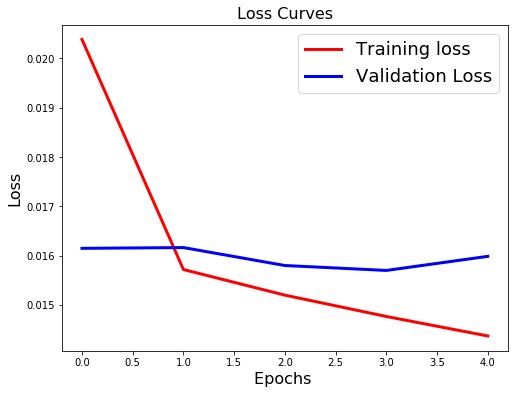

In [14]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

## Conclusions:



1. **BagOfWords:**
    - _SGDRegressor:_
        - Hyperparameters Tuned Values: learning_rate(alpha): 1e-05 and penalty: l2
        - Train MSE Loss: 0.02281
        - CV MSE Loss: 0.02326
    - _Decision Tree:_
        - Hyperparameters Tuned Values: max_depth: 7 and min_samples_leaf: 100
        - Train MSE Loss: 0.0310
        - CV MSE Loss: 0.03128
2. **TFIDF:**
    - _SGDRegressor:_
        - Hyperparameters Tuned Values: learning_rate(alpha): 1e-05 and penalty: l2
        - Train MSE Loss: 0.02556
        - CV MSE Loss: 0.02584
    - _Decision Tree:_
        - Hyperparameters Tuned Values: max_depth: 7 and min_samples_leaf: 100
        - Train MSE Loss: 0.03073
        - CV MSE Loss: 0.03122
3. **LSTM:**
    - Train MSE Loss: 0.0157
    - CV MSE Loss: 0.0162